In [1]:
!pip install tab-transformer-pytorch torch torchvision -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q

print("✅ Đã cài đặt tất cả thư viện!")

✅ Đã cài đặt tất cả thư viện!


In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# TabTransformer
from tab_transformer_pytorch import TabTransformer, FTTransformer

# Sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Tất cả thư viện đã được import thành công!")
print(f"🔥 Đang sử dụng device: {device}")

✅ Tất cả thư viện đã được import thành công!
🔥 Đang sử dụng device: cuda


In [4]:

RAW_DATA_PATH = '/kaggle/input/tabular-stroke-data/synthetic_multimodal.csv'
TARGET_COL = "stroke"
DROP_COLUMNS = ["id", "image_path"]
CATEGORICAL_FEATURES = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status", "hypertension", "heart_disease"]
NUMERICAL_FEATURES = ["age", "avg_glucose_level", "bmi"]
SEED = 42

# Thiết lập random seed cho reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

print("✅ Cấu hình hoàn tất!")

✅ Cấu hình hoàn tất!


In [5]:
# ===========================================================================================
# CELL 4: TẢI VÀ LÀM SẠCH DỮ LIỆU
# ===========================================================================================

print("--- Bắt đầu tải và làm sạch dữ liệu ---")
df = pd.read_csv(RAW_DATA_PATH)
df = df.drop(columns=DROP_COLUMNS, errors='ignore')

# Xử lý BMI
df['bmi'] = df['bmi'].replace('N/A', np.nan)
df['bmi'] = pd.to_numeric(df['bmi'])
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Loại bỏ gender='Other'
df = df[df['gender'] != 'Other'].reset_index(drop=True)

print(f"✅ Dữ liệu đã được làm sạch. Tổng số mẫu: {len(df)}")
print(f"\nPhân bố class:")
print(df[TARGET_COL].value_counts())
print(f"\nTỷ lệ imbalance: {(df[TARGET_COL]==0).sum() / (df[TARGET_COL]==1).sum():.2f}:1")

--- Bắt đầu tải và làm sạch dữ liệu ---
✅ Dữ liệu đã được làm sạch. Tổng số mẫu: 1800

Phân bố class:
stroke
0    1551
1     249
Name: count, dtype: int64

Tỷ lệ imbalance: 6.23:1


In [6]:
# Label Encoding cho categorical features
label_encoders = {}
for col in CATEGORICAL_FEATURES:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Lấy số lượng unique values cho mỗi categorical feature
categories_unique = tuple([df[col].nunique() for col in CATEGORICAL_FEATURES])
print(f"Số lượng unique values trong categorical features: {categories_unique}")

# Tính mean và std cho continuous features (để normalize)
cont_mean_std = torch.tensor(
    df[NUMERICAL_FEATURES].agg(['mean', 'std']).T.values, 
    dtype=torch.float32
)

print(f"\nContinuous features mean and std:")
print(pd.DataFrame(cont_mean_std.numpy(), 
                   index=NUMERICAL_FEATURES, 
                   columns=['mean', 'std']))

# Tách X và y
X_categ = df[CATEGORICAL_FEATURES].values
X_numer = df[NUMERICAL_FEATURES].values
y = df[TARGET_COL].values

print(f"\n✅ Dữ liệu đã được chuẩn bị:")
print(f"   - X_categ shape: {X_categ.shape}")
print(f"   - X_numer shape: {X_numer.shape}")
print(f"   - y shape: {y.shape}")

Số lượng unique values trong categorical features: (2, 2, 5, 2, 4, 2, 2)

Continuous features mean and std:
                         mean        std
age                 45.463310  22.767071
avg_glucose_level  108.676369  47.250385
bmi                 29.092722   7.848186

✅ Dữ liệu đã được chuẩn bị:
   - X_categ shape: (1800, 7)
   - X_numer shape: (1800, 3)
   - y shape: (1800,)


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Huấn luyện model trong 1 epoch"""
    model.train()
    total_loss = 0
    
    for x_cat, x_num, labels in dataloader:
        x_cat, x_num, labels = x_cat.to(device), x_num.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_cat, x_num).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [8]:
def evaluate(model, dataloader, device):
    """Đánh giá model và trả về predictions"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x_cat, x_num, labels in dataloader:
            x_cat, x_num, labels = x_cat.to(device), x_num.to(device), labels.to(device)
            
            outputs = model(x_cat, x_num).squeeze()
            probs = torch.sigmoid(outputs)
            
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, patience=10, verbose=False):
    """
    Huấn luyện model với early stopping
    
    Returns:
        best_model: Model có validation F1-score tốt nhất
        history: Dictionary chứa lịch sử training
    """
    best_f1 = 0
    best_model_state = None
    patience_counter = 0
    history = {'train_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_labels, val_preds = evaluate(model, val_loader, device)
        val_preds_binary = (val_preds >= 0.5).astype(int)
        val_f1 = f1_score(val_labels, val_preds_binary)
        
        history['train_loss'].append(train_loss)
        history['val_f1'].append(val_f1)
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"   Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Val F1: {val_f1:.4f}")
        
        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            if verbose:
                print(f"   Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history, best_f1

In [10]:
# Cấu hình cross-validation
N_SPLITS = 10
REPEATS = 3

# Cấu hình models
MODEL_CONFIGS = {
    'TabTransformer': {
        'dim': 32,
        'depth': 6,
        'heads': 8,
        'attn_dropout': 0.1,
        'ff_dropout': 0.1,
        'mlp_hidden_mults': (4, 2),
        'mlp_act': nn.ReLU(),
        'use_shared_categ_embed': False 
    },
    'FTTransformer': {
        'dim': 32,
        'depth': 6,
        'heads': 8,
        'attn_dropout': 0.1,
        'ff_dropout': 0.1
    }
}

# Cấu hình training
TRAINING_CONFIG = {
    'batch_size': 256,
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'patience': 15,
    'pos_weight': None  # Sẽ được tính trong mỗi fold
}

print("✅ Hyperparameters đã được cấu hình!")
print("\nModel configs:")
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n{model_name}:")
    for k, v in config.items():
        print(f"  {k}: {v}")

✅ Hyperparameters đã được cấu hình!

Model configs:

TabTransformer:
  dim: 32
  depth: 6
  heads: 8
  attn_dropout: 0.1
  ff_dropout: 0.1
  mlp_hidden_mults: (4, 2)
  mlp_act: ReLU()
  use_shared_categ_embed: False

FTTransformer:
  dim: 32
  depth: 6
  heads: 8
  attn_dropout: 0.1
  ff_dropout: 0.1


In [11]:
# ===========================================================================================
# CELL 8: TRAINING LOOP VỚI CROSS-VALIDATION
# ===========================================================================================

print("\n" + "="*80)
print("BẮT ĐẦU TRAINING VỚI CROSS-VALIDATION")
print("="*80)

# Dictionary để lưu kết quả
all_results = {
    name: {'labels': [], 'preds': [], 'best_val_f1': [], 'training_time': []} 
    for name in MODEL_CONFIGS.keys()
}

total_start_time = datetime.now()

for r in range(REPEATS):
    print(f"\n\n{'='*30} REPEAT {r+1}/{REPEATS} {'='*30}")
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED + r)
    
    for fold, (train_val_idx, test_idx) in enumerate(kf.split(X_categ, y)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
        
        # 1. CHIA DỮ LIỆU
        X_categ_train_val, X_categ_test = X_categ[train_val_idx], X_categ[test_idx]
        X_numer_train_val, X_numer_test = X_numer[train_val_idx], X_numer[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]
        
        # Chia train_val thành train và validation (80-20)
        train_size = int(0.8 * len(train_val_idx))
        indices = np.arange(len(train_val_idx))
        np.random.shuffle(indices)
        
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        X_categ_train, X_categ_val = X_categ_train_val[train_indices], X_categ_train_val[val_indices]
        X_numer_train, X_numer_val = X_numer_train_val[train_indices], X_numer_train_val[val_indices]
        y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]
        
        # 2. TÍNH TOÁN TRỌNG SỐ CHO CLASS IMBALANCE
        neg_count = (y_train == 0).sum()
        pos_count = (y_train == 1).sum()
        pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32).to(device)
        print(f"Fold {fold+1} pos_weight: {pos_weight.item():.2f}")
        
        # 3. TẠO DATALOADERS
        train_dataset = TensorDataset(
            torch.tensor(X_categ_train, dtype=torch.long),
            torch.tensor(X_numer_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long)
        )
        val_dataset = TensorDataset(
            torch.tensor(X_categ_val, dtype=torch.long),
            torch.tensor(X_numer_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.long)
        )
        test_dataset = TensorDataset(
            torch.tensor(X_categ_test, dtype=torch.long),
            torch.tensor(X_numer_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.long)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=TRAINING_CONFIG['batch_size'], shuffle=False)
        
        # 4. HUẤN LUYỆN TỪNG MÔ HÌNH
        for model_name, model_config in MODEL_CONFIGS.items():
            print(f"\n🔥 Training {model_name}...")
            start_model_time = datetime.now()
            
            # Tạo model
            if model_name == 'TabTransformer':
                model = TabTransformer(
                    categories=categories_unique,
                    num_continuous=len(NUMERICAL_FEATURES),
                    dim_out=1,
                    continuous_mean_std=cont_mean_std,
                    **model_config
                ).to(device)
            else:  # FTTransformer
                model = FTTransformer(
                    categories=categories_unique,
                    num_continuous=len(NUMERICAL_FEATURES),
                    dim_out=1,
                    **model_config
                ).to(device)
            
            # Loss function với pos_weight
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            
            # Optimizer
            optimizer = optim.AdamW(
                model.parameters(), 
                lr=TRAINING_CONFIG['learning_rate'],
                weight_decay=TRAINING_CONFIG['weight_decay']
            )
            
            # Train
            best_model, history, best_val_f1 = train_model(
                model, train_loader, val_loader, criterion, optimizer,
                num_epochs=TRAINING_CONFIG['num_epochs'],
                device=device,
                patience=TRAINING_CONFIG['patience'],
                verbose=False
            )
            
            # Evaluate trên test set
            test_labels, test_preds = evaluate(best_model, test_loader, device)
            
            # Lưu kết quả
            all_results[model_name]['labels'].append(test_labels)
            all_results[model_name]['preds'].append(test_preds)
            all_results[model_name]['best_val_f1'].append(best_val_f1)
            
            training_time = (datetime.now() - start_model_time).total_seconds()
            all_results[model_name]['training_time'].append(training_time)
            
            # Tính F1 trên test set
            test_preds_binary = (test_preds >= 0.5).astype(int)
            test_f1 = f1_score(test_labels, test_preds_binary)
            
            print(f"✅ Finished {model_name} in {training_time:.1f}s - Val F1: {best_val_f1:.4f}, Test F1: {test_f1:.4f}")
            
            # Clean up
            del model, optimizer, criterion
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\n\n{'='*80}")
print(f"✅ Tổng thời gian thực thi: {datetime.now() - total_start_time}")
print("="*80)


BẮT ĐẦU TRAINING VỚI CROSS-VALIDATION


============================== REPEAT 1/3 ==============================

--- Fold 1/10 ---
Fold 1 pos_weight: 6.76

🔥 Training TabTransformer...
✅ Finished TabTransformer in 12.3s - Val F1: 0.4052, Test F1: 0.3226

🔥 Training FTTransformer...
✅ Finished FTTransformer in 7.2s - Val F1: 0.5158, Test F1: 0.4762

--- Fold 2/10 ---
Fold 2 pos_weight: 6.41

🔥 Training TabTransformer...
✅ Finished TabTransformer in 7.2s - Val F1: 0.3296, Test F1: 0.2930

🔥 Training FTTransformer...
✅ Finished FTTransformer in 7.7s - Val F1: 0.5620, Test F1: 0.4615

--- Fold 3/10 ---
Fold 3 pos_weight: 6.41

🔥 Training TabTransformer...
✅ Finished TabTransformer in 6.2s - Val F1: 0.3566, Test F1: 0.2937

🔥 Training FTTransformer...
✅ Finished FTTransformer in 7.3s - Val F1: 0.5175, Test F1: 0.4416

--- Fold 4/10 ---
Fold 4 pos_weight: 6.53

🔥 Training TabTransformer...
✅ Finished TabTransformer in 30.8s - Val F1: 0.4064, Test F1: 0.2917

🔥 Training FTTransformer...
✅ F

In [12]:
def plot_combined_roc_curve(results, title='Đường cong ROC so sánh các mô hình'):
    """Vẽ đường cong ROC của nhiều mô hình trên cùng một biểu đồ"""
    plt.figure(figsize=(10, 8))
    
    for model_name, data in results.items():
        y_true = data['y_true']
        y_pred_proba = data['y_pred_proba']
        
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.4f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tỷ lệ Dương tính Giả (False Positive Rate)', fontsize=12)
    plt.ylabel('Tỷ lệ Dương tính Thật (True Positive Rate)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [13]:

def plot_single_confusion_matrix(y_true, y_pred, model_name):
    """Vẽ ma trận nhầm lẫn cho một mô hình"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dự đoán 0 (Không đột quỵ)', 'Dự đoán 1 (Có đột quỵ)'],
                yticklabels=['Thực tế 0 (Không đột quỵ)', 'Thực tế 1 (Có đột quỵ)'],
                cbar_kws={'label': 'Số lượng'})
    plt.title(f'Ma trận nhầm lẫn cho: {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Nhãn thực tế', fontsize=12)
    plt.xlabel('Nhãn dự đoán', fontsize=12)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_training_time_comparison(results):
    """Vẽ biểu đồ so sánh thời gian training"""
    model_names = list(results.keys())
    avg_times = [np.mean(results[name]['training_time']) for name in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, avg_times, color=['#3498db', '#e74c3c'])
    plt.ylabel('Thời gian training trung bình (giây)', fontsize=12)
    plt.title('So sánh thời gian training giữa các mô hình', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Thêm giá trị lên đỉnh các cột
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


print("✅ Các hàm trực quan hóa đã được định nghĩa!")

✅ Các hàm trực quan hóa đã được định nghĩa!



KẾT QUẢ SO SÁNH CUỐI CÙNG (TRUNG BÌNH TRÊN 3 REPEATS x 10 FOLDS)

📊 BẢNG METRICS:
                accuracy  precision  recall  f1_score  roc_auc  avg_val_f1  \
TabTransformer    0.6148     0.2138  0.6667    0.3238   0.6912      0.3916   
FTTransformer     0.7098     0.2976  0.8072    0.4349   0.8185      0.4996   

                avg_training_time  
TabTransformer            10.8188  
FTTransformer              8.9701  

--- Đang vẽ đường cong ROC so sánh ---


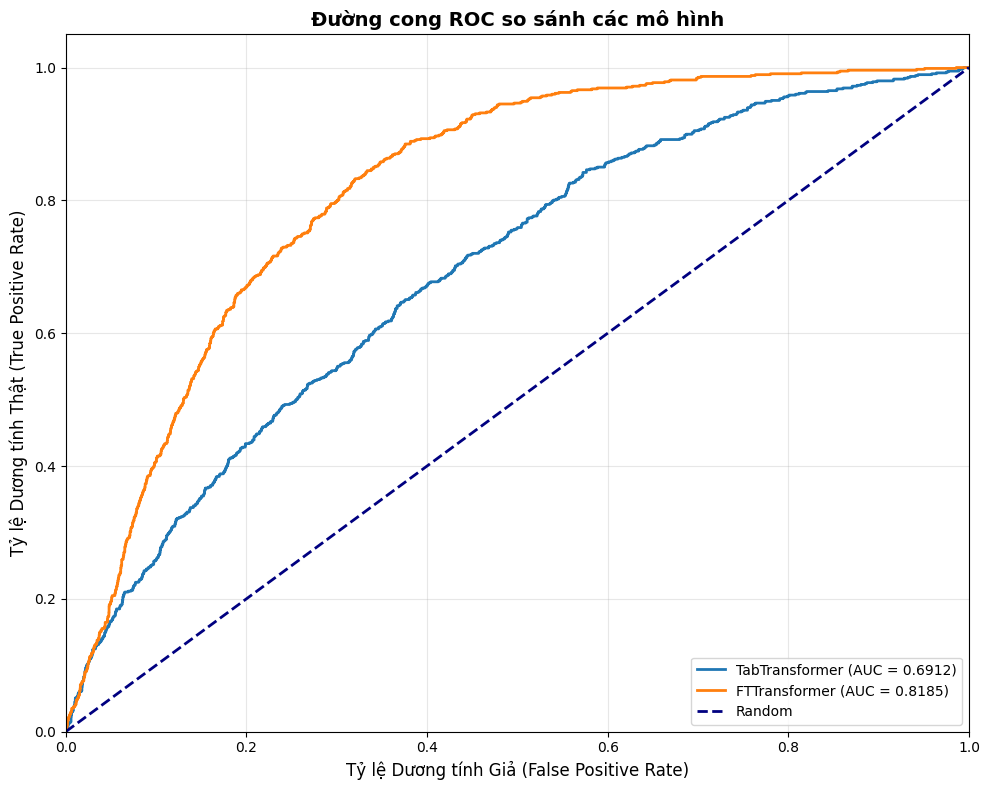


--- Đang vẽ ma trận nhầm lẫn cho tất cả các mô hình ---


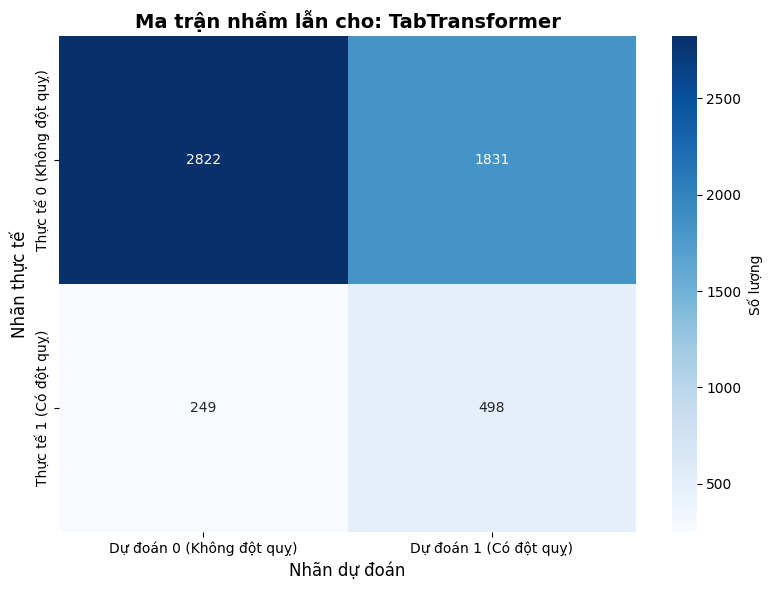

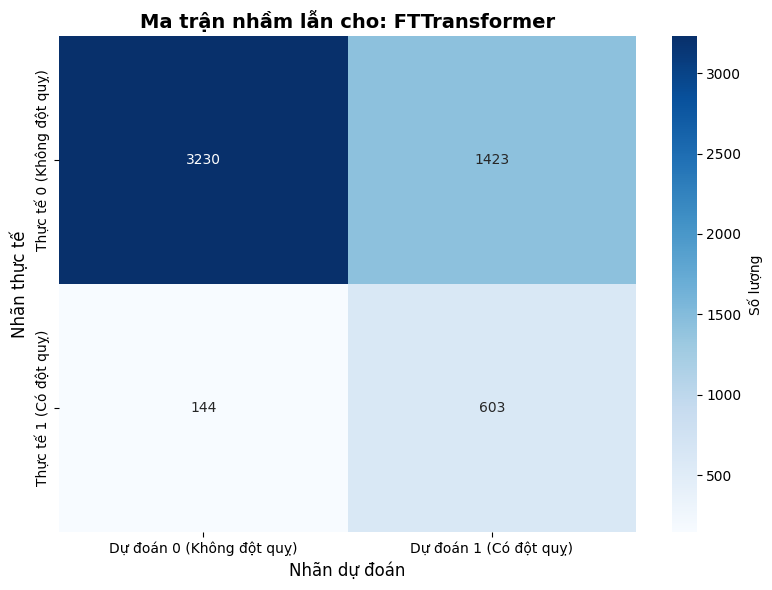


--- Đang vẽ biểu đồ so sánh thời gian training ---


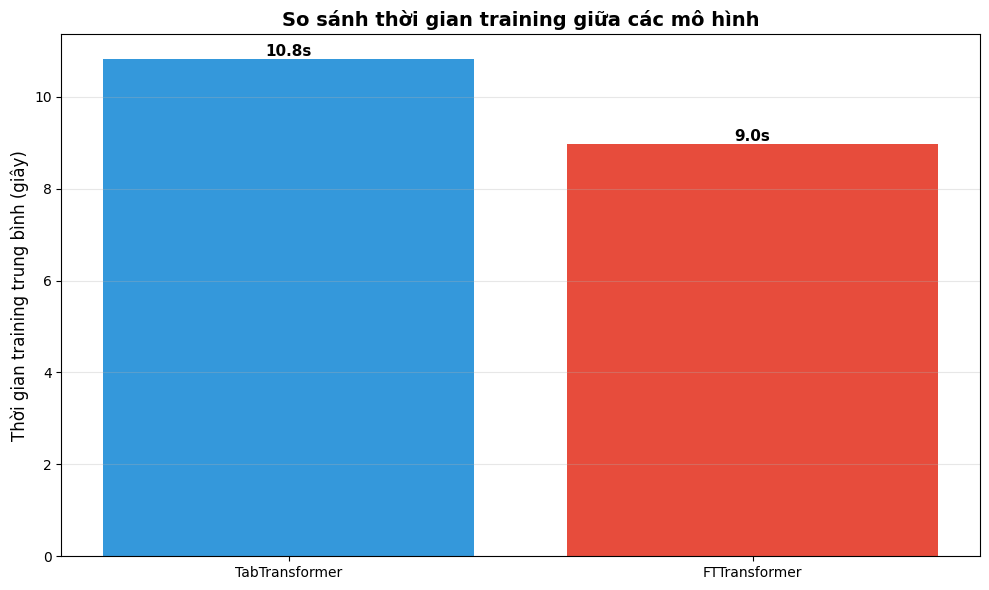

In [15]:
# ===========================================================================================
# CELL 10: ĐÁNH GIÁ VÀ TRỰC QUAN HÓA KẾT QUẢ
# ===========================================================================================

print("\n" + "="*80)
print("KẾT QUẢ SO SÁNH CUỐI CÙNG (TRUNG BÌNH TRÊN 3 REPEATS x 10 FOLDS)")
print("="*80)

final_metrics_summary = {}
final_predictions = {}

for model_name, data in all_results.items():
    # Gộp kết quả từ tất cả các lần chạy
    y_true_all = np.concatenate(data['labels'])
    y_pred_proba_all = np.concatenate(data['preds'])
    y_pred_all = (y_pred_proba_all >= 0.5).astype(int)
    
    # Lưu predictions để vẽ confusion matrix
    final_predictions[model_name] = {
        'y_true': y_true_all,
        'y_pred': y_pred_all,
        'y_pred_proba': y_pred_proba_all
    }
    
    # Tính toán các chỉ số cuối cùng
    metrics = {
        'accuracy': accuracy_score(y_true_all, y_pred_all),
        'precision': precision_score(y_true_all, y_pred_all, zero_division=0),
        'recall': recall_score(y_true_all, y_pred_all),
        'f1_score': f1_score(y_true_all, y_pred_all),
        'roc_auc': roc_auc_score(y_true_all, y_pred_proba_all),
        'avg_val_f1': np.mean(data['best_val_f1']),
        'avg_training_time': np.mean(data['training_time'])
    }
    final_metrics_summary[model_name] = metrics

# In bảng kết quả
results_df = pd.DataFrame(final_metrics_summary).T
print("\n📊 BẢNG METRICS:")
print(results_df.round(4))

# Trực quan hóa ROC AUC của tất cả các mô hình
print("\n--- Đang vẽ đường cong ROC so sánh ---")
plot_combined_roc_curve(
    {name: {'y_true': np.concatenate(data['labels']), 
            'y_pred_proba': np.concatenate(data['preds'])} 
     for name, data in all_results.items()}
)

# Vẽ ma trận nhầm lẫn cho tất cả các mô hình
print("\n--- Đang vẽ ma trận nhầm lẫn cho tất cả các mô hình ---")
for model_name, preds in final_predictions.items():
    plot_single_confusion_matrix(preds['y_true'], preds['y_pred'], model_name)

# Vẽ so sánh thời gian training
print("\n--- Đang vẽ biểu đồ so sánh thời gian training ---")
plot_training_time_comparison(all_results)


In [16]:

# ===========================================================================================
# CELL 11: LƯU KẾT QUẢ METRICS
# ===========================================================================================

output_dir = '/kaggle/working/'
os.makedirs(output_dir, exist_ok=True)

# Lưu bảng metrics
metrics_file = os.path.join(output_dir, 'transformer_comparison_metrics.csv')
results_df.to_csv(metrics_file, index=True)
print(f"✅ Đã lưu bảng metrics vào: {metrics_file}")

print(f"\n📊 Nội dung file:")
print(results_df.round(4))


✅ Đã lưu bảng metrics vào: /kaggle/working/transformer_comparison_metrics.csv

📊 Nội dung file:
                accuracy  precision  recall  f1_score  roc_auc  avg_val_f1  \
TabTransformer    0.6148     0.2138  0.6667    0.3238   0.6912      0.3916   
FTTransformer     0.7098     0.2976  0.8072    0.4349   0.8185      0.4996   

                avg_training_time  
TabTransformer            10.8188  
FTTransformer              8.9701  


In [17]:
print("\n" + "="*80)
print("LƯU CHI TIẾT DỰ ĐOÁN CỦA TỪNG MÔ HÌNH")
print("="*80)

for model_name, preds in final_predictions.items():
    predictions_df = pd.DataFrame({
        'y_true': preds['y_true'],
        'y_pred': preds['y_pred'],
        'y_pred_proba': preds['y_pred_proba']
    })
    
    pred_file = os.path.join(output_dir, f'predictions_transformer_{model_name.lower()}.csv')
    predictions_df.to_csv(pred_file, index=False)
    print(f"✅ Đã lưu predictions của {model_name} vào: {pred_file}")


LƯU CHI TIẾT DỰ ĐOÁN CỦA TỪNG MÔ HÌNH
✅ Đã lưu predictions của TabTransformer vào: /kaggle/working/predictions_transformer_tabtransformer.csv
✅ Đã lưu predictions của FTTransformer vào: /kaggle/working/predictions_transformer_fttransformer.csv


In [18]:
# ===========================================================================================
# CELL 13: TẠO BÁO CÁO TỔNG HỢP
# ===========================================================================================

print("\n" + "="*80)
print("BÁO CÁO TỔNG HỢP")
print("="*80)

report_file = os.path.join(output_dir, 'transformer_experiment_report.txt')

with open(report_file, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("BÁO CÁO KẾT QUẢ TRANSFORMER CHO DỰ ĐOÁN ĐỘT QUỴ\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Thời gian chạy: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Device: {device}\n")
    f.write(f"Tổng số mẫu: {len(df)}\n")
    f.write(f"Số lượng Repeats: {REPEATS}\n")
    f.write(f"Số lượng Folds: {N_SPLITS}\n")
    f.write(f"Tổng số lần đánh giá mỗi mô hình: {REPEATS * N_SPLITS}\n\n")
    
    f.write("-"*80 + "\n")
    f.write("CẤU HÌNH MÔ HÌNH\n")
    f.write("-"*80 + "\n\n")
    for model_name, config in MODEL_CONFIGS.items():
        f.write(f"{model_name}:\n")
        for key, value in config.items():
            f.write(f"  {key}: {value}\n")
        f.write("\n")
    
    f.write("-"*80 + "\n")
    f.write("CẤU HÌNH TRAINING\n")
    f.write("-"*80 + "\n\n")
    for key, value in TRAINING_CONFIG.items():
        f.write(f"{key}: {value}\n")
    
    f.write("\n" + "-"*80 + "\n")
    f.write("KẾT QUẢ METRICS\n")
    f.write("-"*80 + "\n\n")
    f.write(results_df.round(4).to_string())
    f.write("\n\n")
    
    f.write("-"*80 + "\n")
    f.write("XẾP HẠNG MÔ HÌNH THEO F1-SCORE\n")
    f.write("-"*80 + "\n\n")
    ranking = results_df.sort_values('f1_score', ascending=False)
    for idx, (model, row) in enumerate(ranking.iterrows(), 1):
        f.write(f"{idx}. {model}:\n")
        f.write(f"   F1-Score: {row['f1_score']:.4f}\n")
        f.write(f"   ROC-AUC: {row['roc_auc']:.4f}\n")
        f.write(f"   Recall: {row['recall']:.4f}\n")
        f.write(f"   Precision: {row['precision']:.4f}\n")
        f.write(f"   Avg Training Time: {row['avg_training_time']:.1f}s\n\n")
    
    f.write("-"*80 + "\n")
    f.write("SO SÁNH VỚI MÔ HÌNH ML TRUYỀN THỐNG\n")
    f.write("-"*80 + "\n\n")
    f.write("Dựa trên kết quả từ notebook ML truyền thống:\n")
    f.write("- LogisticRegression: F1=0.4652, ROC-AUC=0.8403\n")
    f.write("- CatBoost: F1=0.4646, ROC-AUC=0.8318\n")
    f.write("- XGBoost: F1=0.4640, ROC-AUC=0.8271\n\n")
    
    best_transformer = ranking.index[0]
    best_f1 = ranking.iloc[0]['f1_score']
    best_auc = ranking.iloc[0]['roc_auc']
    
    f.write(f"Transformer tốt nhất: {best_transformer}\n")
    f.write(f"F1-Score: {best_f1:.4f}\n")
    f.write(f"ROC-AUC: {best_auc:.4f}\n\n")
    
    if best_f1 > 0.4652:
        f.write("✅ Transformer VƯỢT TRỘI hơn ML truyền thống!\n")
    elif best_f1 > 0.45:
        f.write("✅ Transformer có hiệu suất TƯƠNG ĐƯƠNG ML truyền thống\n")
    else:
        f.write("⚠️ Transformer CHƯA TỐT BẰNG ML truyền thống\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("KẾT LUẬN\n")
    f.write("="*80 + "\n\n")
    
    f.write("Ưu điểm của Transformer:\n")
    f.write("- Tự động học được representation của categorical features\n")
    f.write("- Có thể capture được complex interactions giữa features\n")
    f.write("- Kiến trúc attention có thể giải thích được (interpretable)\n")
    f.write("- Không cần feature engineering thủ công\n\n")
    
    f.write("Nhược điểm của Transformer:\n")
    f.write("- Training time lâu hơn nhiều so với ML truyền thống\n")
    f.write("- Cần GPU để training hiệu quả\n")
    f.write("- Hyperparameter tuning phức tạp hơn\n")
    f.write("- Có thể overfit với dataset nhỏ\n\n")
    
    f.write("Khuyến nghị:\n")
    if best_f1 > 0.47:
        f.write("- Nên sử dụng Transformer cho production nếu có đủ tài nguyên\n")
        f.write("- Ensemble Transformer với ML truyền thống để tối ưu hóa\n")
    else:
        f.write("- LogisticRegression vẫn là lựa chọn tốt hơn (đơn giản, nhanh, hiệu quả)\n")
        f.write("- Cần tăng kích thước dataset hoặc data augmentation để Transformer phát huy\n")

print(f"✅ Đã lưu báo cáo tổng hợp vào: {report_file}")

# In ra nội dung báo cáo
print("\n" + "="*80)
print("NỘI DUNG BÁO CÁO")
print("="*80)
with open(report_file, 'r', encoding='utf-8') as f:
    print(f.read())


BÁO CÁO TỔNG HỢP
✅ Đã lưu báo cáo tổng hợp vào: /kaggle/working/transformer_experiment_report.txt

NỘI DUNG BÁO CÁO
BÁO CÁO KẾT QUẢ TRANSFORMER CHO DỰ ĐOÁN ĐỘT QUỴ

Thời gian chạy: 2025-12-18 16:51:05
Device: cuda
Tổng số mẫu: 1800
Số lượng Repeats: 3
Số lượng Folds: 10
Tổng số lần đánh giá mỗi mô hình: 30

--------------------------------------------------------------------------------
CẤU HÌNH MÔ HÌNH
--------------------------------------------------------------------------------

TabTransformer:
  dim: 32
  depth: 6
  heads: 8
  attn_dropout: 0.1
  ff_dropout: 0.1
  mlp_hidden_mults: (4, 2)
  mlp_act: ReLU()
  use_shared_categ_embed: False

FTTransformer:
  dim: 32
  depth: 6
  heads: 8
  attn_dropout: 0.1
  ff_dropout: 0.1

--------------------------------------------------------------------------------
CẤU HÌNH TRAINING
--------------------------------------------------------------------------------

batch_size: 256
num_epochs: 100
learning_rate: 0.001
weight_decay: 1e-05
patien